In [18]:
import numpy as np
import matplotlib.pyplot as plt
import metrics
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sneiaTools import metrics

In [3]:
# Number of samples
N = 10000

"""
Generate a sine wave

Generates an array of N parts starting at 0 and ending at 10π.
Calculates the sine of each element of the array t to eventually compare it with the original values 
and use the same original values as a time scale for the plot.
"""
t = np.linspace(0, 10*np.pi, N)
original_signal = np.sin(t)

"""
Contaminate signal

In the noise variable an array of size N is stored where all values rotate around 0 with a standard deviation 
of 0.5. To contaminate the signal, the noise is added to each value of the sine signal.
"""
noise = np.random.normal(0, 0.5, N)
contaminated_signal = original_signal + noise

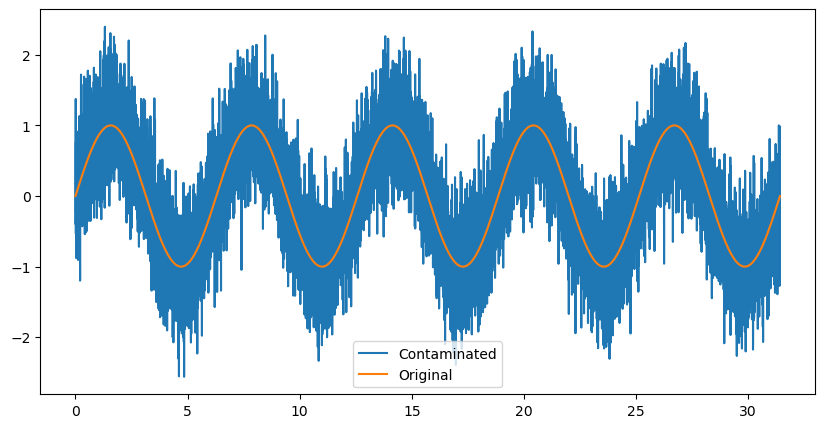

In [4]:
# Plot the original and the contaminated signals
plt.figure(figsize=(10,5))
plt.plot(t, contaminated_signal, label="Contaminated")
plt.plot(t, original_signal, label="Original")
plt.legend()
plt.show()


In [6]:
# definir si se esta accediando correctamente a el slicing de output_data, ya que es distinto al de input_data
def create_sequences(input_data, output_data, seq_length):
    xs, ys = [], []
    
    for i in range( len( input_data ) - seq_length ):
        x = input_data[i:(i+seq_length)]
        y = output_data[i+seq_length]
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)

seq_length = 75
X, y = create_sequences(contaminated_signal, original_signal, seq_length)

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the inputs for LSTM NN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [8]:
# Build the LSTM model
model = Sequential()

# First LSTM layer with reduced dropout and L1 regularization
model.add(LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True,
               dropout=0.05, recurrent_dropout=0.05, 
               kernel_regularizer=l1(0.0001), recurrent_regularizer=l1(0.0001)))
"""
# Second LSTM layer with reduced dropout and L1 regularization
model.add(LSTM(256, return_sequences=True, 
               dropout=0.05, recurrent_dropout=0.05,
               kernel_regularizer=l1(0.0001), recurrent_regularizer=l1(0.0001)))

# Third LSTM layer with reduced dropout and L2 regularization
model.add(LSTM(128, return_sequences=True, 
               dropout=0.05, recurrent_dropout=0.05,
               kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001)))
"""
# Fourth LSTM layer with reduced dropout and L2 regularization
model.add(LSTM(64, return_sequences=False, 
               dropout=0.05, recurrent_dropout=0.05,
               kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=Adam())




In [11]:
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False, callbacks=[early_stopping])

Epoch 1/10
249/249 [==============================] - 106s 424ms/step - loss: 0.0357 - val_loss: 0.0253
Epoch 2/10
249/249 [==============================] - 112s 449ms/step - loss: 0.0216 - val_loss: 0.0175
Epoch 3/10
249/249 [==============================] - 107s 431ms/step - loss: 0.0168 - val_loss: 0.0142
Epoch 4/10
249/249 [==============================] - 99s 397ms/step - loss: 0.0147 - val_loss: 0.0127
Epoch 5/10
249/249 [==============================] - 96s 385ms/step - loss: 0.0135 - val_loss: 0.0124
Epoch 6/10
249/249 [==============================] - 94s 376ms/step - loss: 0.0129 - val_loss: 0.0117
Epoch 7/10
249/249 [==============================] - 96s 387ms/step - loss: 0.0122 - val_loss: 0.0108
Epoch 8/10
249/249 [==============================] - 117s 469ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 9/10
249/249 [==============================] - 108s 430ms/step - loss: 0.0113 - val_loss: 0.0101
Epoch 10/10
249/249 [==============================] - 109s 437ms/st

In [13]:
model.save('sin_LSTM.h5')

In [17]:
# Reshape the inputs for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Make predictions on all data
y_pred = model.predict(X)

# Shift the predicted data
y_pred_shifted = np.roll(y_pred, shift=seq_length, axis=0)

# Since we can't predict the first 'seq_length' samples with this method, we can just set them to zero
y_pred_shifted[:seq_length] = 0

# Trim the original signal to match the predicted signal
original_signal_trimmed = original_signal[seq_length:-seq_length]

311/311 [==============================] - 20s 65ms/step


In [19]:
x = metrics.mse(y_pred, y)

TypeError: Metrics.mse() missing 2 required positional arguments: 'predictions' and 'target'

In [ ]:
mape_1 = MAPE(original_signal_trimmed, y_pred)
print("MAPE: ", mape_1)

MAPE:  392.17611988102334


In [ ]:
sigma_e = metrics.re(original_signal_trimmed, y_pred_all)
print("Sigma_e: ", sigma_e)

NameError: name 'original_signal_trimmed' is not defined

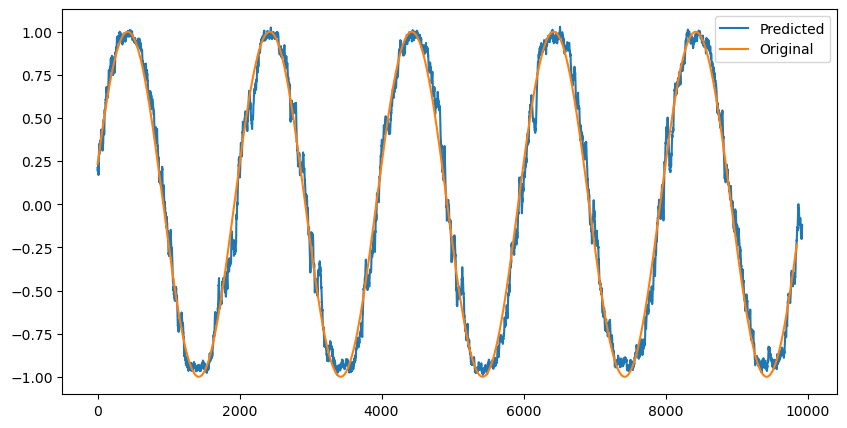

In [ ]:
# Plot the predicted vs trimmed original signal
plt.figure(figsize=(10,5))
plt.plot(y_pred_all, label="Predicted")
plt.plot(original_signal_trimmed, label="Original")
plt.legend()
plt.show()

# Implicaciones del uso de L1 y Dropout

Al momento de agregar estas 2 herramientas se crean "valles" en los picos de las señales, pero a pesar de esto estas 2 tecnicas tienen efectos positivos en el indice de RMSE

# Resultados de aumento en la complejidad

Se observa una mejora considerable en los resultados al aumentar la cantidad de capas y neuronas

Remuestrear señales